## Word2Bits Embeddings' recommender evaluation

Here we evaluate how well the word2bits embedding representation of documents performs in a task of modelling the user preferences, which is crucial for example for recommending a relevant content.

The experiment is performed in following steps:

* We split the content of a user into "past" and "future"
* We create a profile of the user based on a pash content - the profile is represented as an avereage of the seen documents, where a document is represented again as an average of its word2bits-embedded words
* We evaluate a direct similarity of the future content with the user profile
* We evaluate a similarity of each of the future content with the user profile and compare it to the baseline - average distance of the user profile towards all of the present content

In [1]:
import pandas as pd

movies_desc = pd.read_csv("/data/misc/thesis/recommender/themovies/movies_metadata.csv")
movies_desc.head()

/home/michal/miniconda3/envs/doc_analyzer/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [39]:
movies_desc.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [2]:
movies_desc.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [3]:
ratings = pd.read_csv("/data/misc/thesis/recommender/themovies/ratings_small.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
ratings["userId"].value_counts().hist()

In [5]:
id_mapping = pd.read_csv("/data/misc/thesis/recommender/themovies/links_small.csv")
id_mapping.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
ratings["imdbId"] = ratings["movieId"].map(id_mapping.set_index("movieId")["imdbId"])
ratings.head()

,userId,movieId,rating,timestamp,imdbId
0,1,31,2.5,1260759144,112792
1,1,1029,3.0,1260759179,33563
2,1,1061,3.0,1260759182,117665
3,1,1129,2.0,1260759185,82340
4,1,1172,4.0,1260759205,95765


In [7]:
ratings_movies_join = ratings.set_index("imdbId").join(movies_desc, how="inner")

In [8]:
ratings_movies = ratings_movies_join.set_index(["userId", "movieId"])[["timestamp", "rating", "overview"]].reset_index()
ratings_movies.head()

,userId,movieId,timestamp,rating,overview
0,262,32898,1433939390,3.0,Emma is an attractive girl in her 20s who has ...
1,299,32898,1344428080,4.5,Emma is an attractive girl in her 20s who has ...
2,378,32898,1443292552,4.0,Emma is an attractive girl in her 20s who has ...
3,468,32898,1296194638,4.5,Emma is an attractive girl in her 20s who has ...
4,481,32898,1437005548,5.0,Emma is an attractive girl in her 20s who has ...


In [10]:
# split user reviews
split_quantiles = ratings_movies.groupby("userId")["timestamp"].quantile(q=0.75)

past_user_dfs = []
for uid in split_quantiles.index:
    past_user_dfs.append(ratings_movies[(ratings_movies["userId"] == uid) & (ratings_movies["timestamp"] < split_quantiles.loc[uid])])
past_users_ratings = pd.concat(past_user_dfs)

future_user_dfs = []
for uid in split_quantiles.index:
    future_user_dfs.append(ratings_movies[(ratings_movies["userId"] == uid) & (ratings_movies["timestamp"] >= split_quantiles.loc[uid])])
future_users_ratings = pd.concat(future_user_dfs)

In [11]:
ratings_movies.__len__()

3403

In [12]:
past_users_ratings.__len__()

2339

In [13]:
future_users_ratings

,userId,movieId,timestamp,rating,overview
1600,1,1029,1260759179,3.0,On the set of a dark war time drama at an old ...
731,4,594,949949538,5.0,Chuck Scott gets a job as chauffeur to tough g...
1401,4,596,949949638,5.0,"The Blue Planet, the definitive exploration of..."
2828,4,1022,949949638,5.0,Young Simone gets hit by a near fatal car cras...
3056,4,1032,949949538,5.0,A romance between an MI6 code genius and an or...
1073,5,919,1163374286,4.0,A present-day idyllic kingdom where the benevo...
1402,6,596,1108134269,4.0,"The Blue Planet, the definitive exploration of..."
732,7,594,851868020,4.0,Chuck Scott gets a job as chauffeur to tough g...
1514,11,923,1391658556,5.0,Times are hard for habitual guest of Her Majes...
2958,12,3780,968045619,2.0,A postman learns that he doesn't have much tim...


In [14]:
past_users_ratings

,userId,movieId,timestamp,rating,overview
196,4,2102,949949396,5.0,Jost roams through the streets of Berlin. He o...
1072,4,919,949949396,5.0,A present-day idyllic kingdom where the benevo...
1204,4,1282,949949396,5.0,A beautiful housekeeper becomes a romantic att...
1667,4,913,949919247,5.0,"On May 9, 1986, a small ranching community in ..."
1766,4,2018,949778771,5.0,Three men and their accidental meeting on a br...
2829,5,1022,1163373316,4.0,Young Simone gets hit by a near fatal car cras...
3057,12,1032,968045561,2.0,A romance between an MI6 code genius and an or...
80,15,3742,1082220261,2.5,A terrifying tale of survival in the mangrove ...
128,15,2010,1052896685,3.0,The Hangover crew heads to Thailand for Stu's ...
253,15,3307,1082220247,3.0,"In 1921 Dublin, the IRA battles the ""Black &am..."


In [ ]:
# reprezentacia dokumentov s Word Mover's distance

In [15]:
future_users_ratings.__len__()

1064

### Evaluate the difference of the users' own good-rated movies compared to a baseline (other ratings) 

In [17]:
vecs_df = pd.read_csv("../../vectors/1b600d_vectors_e10_sample1e4_nonbin", 
                      skiprows=[0, 1], header=None, sep=" ")
vecs_df = vecs_df.set_index(0)
vecs_df = vecs_df.drop(columns=[vecs_df.columns[-1]])
vecs_df = vecs_df.replace(vecs_df.values.max(), 1)
vecs_df = vecs_df.replace(vecs_df.values.min(), 0)
# retype to minimal range int to save space
w2b_model = vecs_df.astype('int8')
w2b_model.head(5)

,1,2,3,4,5,6,7,8,9,10,...,591,592,593,594,595,596,597,598,599,600
0,,,,,,,,,,,,,,,,,,,,,
the,0,0,1,1,0,0,1,0,1,1,...,0,1,1,1,0,1,1,1,0,1
of,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,1,1,0,1,1,1
and,0,0,1,1,0,1,1,0,0,0,...,0,1,1,1,0,0,1,1,0,1
one,0,0,0,1,0,0,1,0,1,0,...,1,1,0,0,1,0,0,1,0,1
in,0,1,1,1,1,0,1,0,1,0,...,1,1,0,1,1,0,0,1,1,1


In [18]:
def get_word_vec(wordlist):
    for word in wordlist:
        try:
            yield vecs_df.loc[word]
        except KeyError: 
            pass

### Generating user profiles

User profile is a representation of the liked content in a w2b space

In [19]:
past_users_ratings[past_users_ratings["userId"] == 4]["overview"]

196     Jost roams through the streets of Berlin. He o...
1072    A present-day idyllic kingdom where the benevo...
1204    A beautiful housekeeper becomes a romantic att...
1667    On May 9, 1986, a small ranching community in ...
1766    Three men and their accidental meeting on a br...
Name: overview, dtype: object

In [20]:
from functools import reduce
# user_profile_overviews = 
user_profiles_txt = past_users_ratings[past_users_ratings["rating"].isin((4, 5))].groupby("userId")["overview"] \
                                .agg(lambda s: reduce(lambda x, y: " ".join([str(x), str(y)]), s))

In [21]:
user_profiles_txt.head()

userId
4     Jost roams through the streets of Berlin. He o...
5     Young Simone gets hit by a near fatal car cras...
15    Times are hard for habitual guest of Her Majes...
17    Popular mailcoach driver Uncle Willie is in fa...
19    After serving a 12-year sentence for killing t...
Name: overview, dtype: object

In [22]:
# homogenize words:
from gensim.parsing.preprocessing import preprocess_string
import numpy as np

In [23]:
past_user_profiles = user_profiles_txt.apply(lambda x: preprocess_string(str(x))).apply(get_word_vec) \
                            .apply(lambda vec_gen: np.mean(list(vec_gen), axis=0))

/home/michal/miniconda3/envs/doc_analyzer/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [24]:
baseline_future_content = future_users_ratings[future_users_ratings["rating"].isin((4, 5))]["overview"] \
                                .apply(lambda x: preprocess_string(str(x))).apply(get_word_vec) \
                                .apply(lambda vec_gen: np.mean(list(vec_gen), axis=0)) \
                                .mean(axis=0)

/home/michal/miniconda3/envs/doc_analyzer/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [25]:
future_user_profiles = future_users_ratings[future_users_ratings["rating"].isin((4, 5))] \
                                .groupby("userId")["overview"] \
                                .agg(lambda s: reduce(lambda x, y: " ".join([str(x), str(y)]), s)) \
                                .apply(lambda x: preprocess_string(str(x))).apply(get_word_vec) \
                                .apply(lambda vec_gen: np.mean(list(vec_gen), axis=0))

/home/michal/miniconda3/envs/doc_analyzer/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [26]:
# diff for each user against his future scores and a baseline
from scipy.spatial.distance import cosine

past_future_join = pd.concat([past_user_profiles, future_user_profiles], axis=1)
past_future_join.columns = ["past_vec", "future_vec"]
nonempty_own_diff_vecs = past_future_join[~past_future_join.apply(pd.isnull).any(axis=1)]
nonempty_own_diffs = nonempty_own_diff_vecs.apply(lambda row: cosine(row["past_vec"], row["future_vec"]), axis=1)
nonempty_own_diffs.describe()

count    162.000000
mean       0.062521
std        0.081654
min        0.002229
25%        0.015624
50%        0.031990
75%        0.073003
max        0.327193
dtype: float64

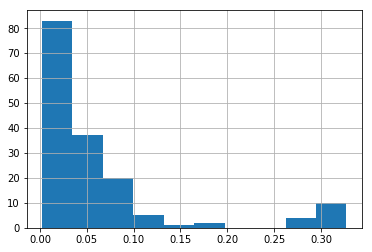

In [27]:
nonempty_own_diffs.hist()

In [28]:
past_future_join
nonempty_baseline_diffs = nonempty_own_diff_vecs.apply(lambda row: cosine(row["past_vec"], baseline_future_content), axis=1)
nonempty_baseline_diffs.describe()

count    162.000000
mean       0.025116
std        0.048388
min        0.001085
25%        0.004432
50%        0.010620
75%        0.022596
max        0.255265
dtype: float64

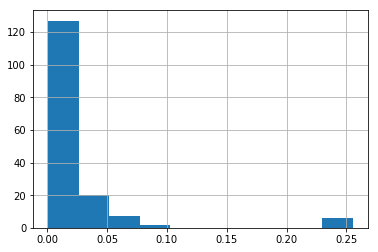

In [29]:
nonempty_baseline_diffs.hist()

In [35]:
past_users_ratings[(past_users_ratings["userId"] == 4) & (past_users_ratings["movieId"] == 2102)]["overview"].values

array(['Jost roams through the streets of Berlin. He opposes the world enraged, aggressively and furiously in a self-destructive way. He continuously provokes situations proving to himself that everybody hates him. He is convinced he does not need anybody and does not let anyone get close to him.  Anna is walled in by her fear and unable to leave her apartment. She manages to keep this situation from all the others in a system of lies. Her reserves draw to a close. She heads for a catastrophe.  One day, Jost shows up at her door.'],
      dtype=object)

In [38]:
np.array(list(get_word_vec(past_users_ratings))).

[1      1.0
 2      1.0
 3      1.0
 4      0.0
 5      1.0
 6      1.0
 7      1.0
 8      0.0
 9      0.0
 10     0.0
 11     1.0
 12     0.0
 13     1.0
 14     0.0
 15     0.0
 16     0.0
 17     1.0
 18     1.0
 19     1.0
 20     1.0
 21     0.0
 22     1.0
 23     1.0
 24     1.0
 25     0.0
 26     1.0
 27     0.0
 28     1.0
 29     0.0
 30     1.0
       ... 
 571    0.0
 572    0.0
 573    0.0
 574    0.0
 575    0.0
 576    0.0
 577    0.0
 578    0.0
 579    1.0
 580    0.0
 581    1.0
 582    1.0
 583    0.0
 584    1.0
 585    1.0
 586    0.0
 587    0.0
 588    1.0
 589    1.0
 590    0.0
 591    1.0
 592    1.0
 593    0.0
 594    0.0
 595    0.0
 596    0.0
 597    1.0
 598    1.0
 599    1.0
 600    1.0
 Name: timestamp, Length: 600, dtype: float64, 1      0.0
 2      1.0
 3      0.0
 4      1.0
 5      0.0
 6      1.0
 7      1.0
 8      0.0
 9      1.0
 10     1.0
 11     1.0
 12     1.0
 13     1.0
 14     1.0
 15     1.0
 16     1.0
 17     1.0
 18     1.0
 19   